In [75]:
import os
from glob import glob
import pandas as pd
import numpy as np
import json

%matplotlib inline

In [2]:
directories = glob('../text/*')
directories

['../text/movie-enter',
 '../text/kaden-channel',
 '../text/sports-watch',
 '../text/it-life-hack',
 '../text/dokujo-tsushin',
 '../text/peachy',
 '../text/smax',
 '../text/topic-news',
 '../text/livedoor-homme']

In [7]:
dir_labels = dict(zip(directories, range(len(directories))))
dir_labels

{'../text/dokujo-tsushin': 4,
 '../text/it-life-hack': 3,
 '../text/kaden-channel': 1,
 '../text/livedoor-homme': 8,
 '../text/movie-enter': 0,
 '../text/peachy': 5,
 '../text/smax': 6,
 '../text/sports-watch': 2,
 '../text/topic-news': 7}

In [29]:
texts, labels = [], []
for dir_i, label_i in dir_label_list.items():
    file_list = glob('%s/*.txt' % dir_i)
    
    for file_i in file_list:
        with open(file_i, encoding='utf-8') as f:
            text = ''.join(f.readlines()[2:])
            texts.append(text)
            labels.append(label_i)

In [31]:
len(texts), len(labels)

(7376, 7376)

In [32]:
texts[9]

'都内開運スポットをそぞろ歩き\n\u3000近年、パワースポット人気は増すばかり。明治神宮の「清正井」などは、朝から行列ができるほどで、芸能人も多く訪れているそうです。今では日本各地のパワースポットがネットや雑誌で紹介されており、北海道から沖縄まで、さまざまな霊気の宿る場所へ出かけるのが、女子たちの旅の目的のひとつとなっているのではないでしょうか？\n\u3000\n\u3000そんな全国へ訪れるパワースポット巡りも素敵ですが、自分が住む周辺の街でも簡単に、開運できるスポットがあるのをご存じでしょうか？それが七福神巡り。七福神巡りとは、恵比寿天、寿老人、大黒天、福禄寿、毘沙門天、弁財天、布袋尊のそれぞれの福の神が祀られた寺社を参拝し、7つの災いと7つの福を呼びこむ、室町時代から続く祈願巡りなのです。\n\n\u3000本来の七福神巡りは、お正月に行うのが一般的ですが、お寺に方に聞くと、最近では街の散策を楽しみながら七福神を参拝し、祈願をする女性もたくさんいらっしゃるそうです。そこで私、編集部Mも七福神巡りを初体験してみました。\n\n\u3000都内には七福神巡りを行える街が数多くあり、下町だけでも「谷中」「浅草」「北千住」など、どの街を巡ろうか迷うほどにあります。その中で今回私が選んだのは、寅さんで有名な「柴又七福神巡り」。この街は、私が住む街からたった1駅で気軽に訪れることができる場所です。\n\n\u3000「柴又七福神巡り」は、寅さん像のある京成柴又駅からスタート。駅で無料配布の柴又マップを貰い、地図に沿ってそぞろ歩きを始めます。マップには「七福神巡り」のコース例も載っているので、とても便利です。また、七福神巡りを記念に残すには、最初のお寺で色紙(200円)をもらい、各寺で御朱印（200円）を貰っていくこともできます。\n\nお寺へ向かう道では、団子屋に鰻屋、そして屋台が並び活気あふれる帝釈天・題経時（毘沙門天）までの参道に、京成電車のすぐ脇道を通る宝袋尊・良観寺、そして閑静な住宅街の中にひっそりと佇む大黒天・宝生院など、下町あふれる風情が存分に味わえ、充実した散策も楽しめます。\n\n\u3000また、それぞれのお寺の清らかさは、訪れる度に心が洗われていくのを実感。中でも真勝院（弁財天）の静寂さは、境内に入った瞬間に「この場所はなぜか心地よい」と感じられ

名詞の抽出

In [36]:
import MeCab
from gensim import corpora, matutils

mecab = MeCab.Tagger('-Ochasen')

In [34]:
def get_nouns(text):
    nouns = []
    res = mecab.parse(text)
    words = res.split('\n')[:-2] #EOSと空白部分の削除
    for word in words:
        part = word.split('\t')
        if '名詞' in part[3]:
            nouns.append(part[0])
    return nouns

In [35]:
word_collect = []
for text in texts:
    nouns = get_nouns(text)
    word_collect.append(nouns)

In [41]:
# dictionaryに格納して、top20に絞る
dictionary = corpora.Dictionary(word_collect)
dictionary.filter_extremes(no_below=20)
len(dictionary)

7494

In [42]:
# BOWする
n_words = len(dictionary)
x = []
for nouns in word_collect:
    bow_id = dictionary.doc2bow(nouns)
    bow = matutils.corpus2dense([bow_id], n_words).T[0]
    x.append(bow)

In [45]:
x = np.array(x, 'float32')
t = np.array(labels, 'int32')

In [46]:
x.shape, t.shape

((7376, 7494), (7376,))

In [47]:
x.dtype, t.dtype

(dtype('float32'), dtype('int32'))

### モデル作成

In [68]:
from chainer.datasets import TupleDataset, split_dataset_random
import chainer
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater, Trainer
from chainer.training.extensions import Evaluator, LogReport, PrintReport

In [65]:
# dataset 
dataset = TupleDataset(x, t)

train, test = split_dataset_random(dataset, 
                                   int(len(dataset)*0.7))

In [66]:
def model_evaluation(nn, epoch=10, batch_size=16, use_gpu=True):
    np.random.seed(0)
    epoch=setting['epoch']
    batch_size=setting['batch_size']
    use_gpu=setting['use_gpu']

    # Model Instance
    model = L.Classifier(nn)
    
    if use_gpu:
        device = 0
        model.to_gpu(device)
    else:
        device = -1
    
    # ミニバッチのインスタンスを作成
    train_iter = SerialIterator(train, batch_size)
    test_iter = SerialIterator(test, batch_size, repeat=False, shuffle=False)
    
    # Set Lerning
    optimizer = Adam()
    optimizer.setup(model)
    
    updater = StandardUpdater(train_iter, optimizer, device=device)

    trainer = Trainer(updater, (epoch, 'epoch'), out='result/text')
    trainer.extend(Evaluator(test_iter, model, device=device))
    trainer.extend(LogReport(trigger=(1, 'epoch')))
    trainer.extend(PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 
                                'main/loss', 'validation/main/loss', 'elapsed_time']), 
                   trigger=(1, 'epoch'))
    
    trainer.run()
    
    if use_gpu:
        model.to_cpu()

    return model
        
def visualize_result():
    with open('./result/text/log') as f:
        result = pd.DataFrame(json.load(f))
        
    print('Elapsed time: %d sec' % result.iloc[-1]['elapsed_time'])
    print('Validation accuracy:', result.iloc[-1]['validation/main/accuracy'])
    result[['main/accuracy', 'validation/main/accuracy']].plot()
    return result

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.839423       0.929833                  0.651187    0.264467              2.66022       
2           0.981538       0.945786                  0.0868497   0.213773              5.18105       
3           0.998039       0.945786                  0.0282723   0.203314              7.60238       
4           0.998654       0.942441                  0.0166231   0.21963               10.0699       
5           0.998654       0.946656                  0.0121457   0.209953              12.5584       
6           0.999608       0.945351                  0.008824    0.216972              15.1116       
7           0.999808       0.949264                  0.00664317  0.215485              17.6221       
8           0.999615       0.949264                  0.00575864  0.219126              20.0921       
9           1              0.949264                  0.00467988  0.223068           

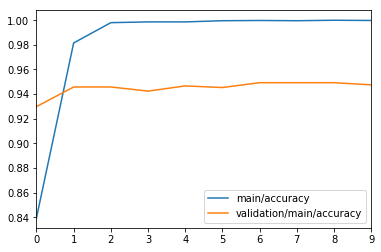

In [78]:
class NN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, 500)
            self.fc_out = L.Linear(None, 9)
            
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = F.dropout(h)
        h = self.fc_out(h)
        return h

setting = {
    'epoch': 10,
    'batch_size': 100,
    'use_gpu': False
}
model_evaluation(NN(), setting)
result = visualize_result()

In [79]:
F.dropout?